# Input Analysis

This notebook contains our analysis of the input data sets to understand the basic demographic distribution before we run experiments.

## Setup

First, we want to load some libraries.

In [1]:
library(dplyr)
library(readr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
options(repr.plot.height=5)
options(repr.matrix.max.rows=10)
options(repr.matrix.max.columns=10)

In [3]:
source("plot-tools.R")

In [4]:
ml_age_bins = c("1"="1-17", "18"="18-24", "25"="25-34", "35"="35-44", "45"="45-49", "50"="50-55", "56"="56+")
ml_age_lbs = c(1, 18, 25, 35, 45, 50, 56)

bound_ages = function(ages, bounds=ml_age_lbs) {
    ages[ages <= 0] = NA
    selectors = rowSums(outer(ages, ml_age_lbs, ">="))
    factor(ml_age_bins[selectors], levels=ml_age_bins, ordered=TRUE)
}

rename_ages = function(ages) {
    factor(ml_age_bins[ages], levels=ml_age_bins, ordered=TRUE)
}

## Load MovieLens data

We want to read the ML-1M ratings file:

In [5]:
ml_ratings = read_delim("data/ml-1m/ratings.dat", delim=":",
                        col_names=c("user", "item", "rating", "timestamp"),
                        col_types="i_i_i_i")
ml_ratings

user,item,rating,timestamp
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291
⋮,⋮,⋮,⋮
6040,1091,1,956716541
6040,1094,5,956704887
6040,562,5,956704746
6040,1096,4,956715648


# Create Session ids

In [6]:
sessionize = function(ts) {
    delta.t = diff(ts)
    is.new = c(TRUE, delta.t >= 3600)
    cumsum(is.new)
}
sessions = ml_ratings %>%
    group_by(user) %>%
    arrange(timestamp) %>%
    mutate(sessionId = sessionize(timestamp))

ml_ratings =sessions

And load in the per-user data:

In [7]:
ml_users = read_delim("data/ml-1m/users.dat", delim=":",
                      col_names=c("user", "gender", "age", "occupation", "zip"),
                      col_types="i_c_c_c_c") %>%
    rename(rawAge=age) %>%
    mutate(gender=as.factor(gender),
           age=rename_ages(rawAge),
           occupation=as.factor(occupation))
ml_users

user,gender,rawAge,occupation,zip,age
1,F,1,10,48067,1-17
2,M,56,16,70072,56+
3,M,25,15,55117,25-34
4,M,45,7,02460,45-49
5,M,25,20,55455,25-34
⋮,⋮,⋮,⋮,⋮,⋮
6036,F,25,15,32603,25-34
6037,F,45,1,76006,45-49
6038,F,56,1,14706,56+
6039,F,45,0,01060,45-49


In [8]:
ml_item_stats = ml_ratings %>%
    group_by(item) %>%
    summarize(RatingCount=n(),
              MeanRating=mean(rating),
              MinRating=min(rating),
              MaxRating=max(rating)             
             ) %>%
    mutate(PopRank=rank(-RatingCount))
ml_item_stats

item,RatingCount,MeanRating,MinRating,MaxRating,PopRank
1,2077,4.146846,1,5,30.0
2,701,3.201141,1,5,394.5
3,478,3.016736,1,5,650.0
4,170,2.729412,1,5,1574.0
5,296,3.006757,1,5,1067.0
⋮,⋮,⋮,⋮,⋮,⋮
3948,862,3.635731,1,5,278.0
3949,304,4.115132,1,5,1037.5
3950,54,3.666667,1,5,2449.5
3951,40,3.900000,1,5,2663.5


In [9]:
ml_user_stats = ml_ratings %>%
    inner_join(ml_item_stats %>% select(item, RatingCount, PopRank)) %>%
    group_by(user) %>%
    summarize(RatingCount=n(),
              MeanRating=mean(rating),
              MinRating=min(rating),
              MaxRating=max(rating),
              MeanPopRank=mean(PopRank),
              MedRatingCount=median(RatingCount),
              SessionCount=max(sessionId),
              AccountLifetime=max(timestamp) - min(timestamp)) %>%
    inner_join(ml_users)
ml_user_stats

Joining, by = "item"
Joining, by = "user"


user,RatingCount,MeanRating,MinRating,MaxRating,MeanPopRank,MedRatingCount,SessionCount,AccountLifetime,gender,rawAge,occupation,zip,age
1,53,4.188679,3,5,397.9811,53,2,524332,F,1,10,48067,1-17
2,129,3.713178,1,5,454.5698,129,1,2050,M,56,16,70072,56+
3,51,3.901961,1,5,289.4706,51,1,1486,M,25,15,55117,25-34
4,21,4.190476,1,5,148.5476,21,1,358,M,45,7,02460,45-49
5,198,3.146465,1,5,832.9268,198,1,5513,M,25,20,55455,25-34
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6036,888,3.302928,1,5,954.6430,888,2,45847,F,25,15,32603,25-34
6037,202,3.717822,1,5,561.6485,202,3,92843,F,45,1,76006,45-49
6038,20,3.800000,1,5,482.4250,20,2,10377,F,56,1,14706,56+
6039,123,3.878049,2,5,701.7967,123,2,52871,F,45,0,01060,45-49


## Bring Data Together

In [10]:
all_item_stats =
    bind_rows(ML=ml_item_stats %>% select(item, UserCount=RatingCount),
              
              .id="DataSet")
all_item_stats

DataSet,item,UserCount
ML,1,2077
ML,2,701
ML,3,478
ML,4,170
ML,5,296
⋮,⋮,⋮
ML,3948,862
ML,3949,304
ML,3950,54
ML,3951,40


In [11]:
all_user_stats =
    bind_rows(ML=ml_user_stats %>% select(user, gender, age, ItemCount=RatingCount,SessionCount),
              
              .id="DataSet") %>%
    mutate(Retention = ifelse(SessionCount>1, 1, 0))
all_user_stats

DataSet,user,gender,age,ItemCount,SessionCount,Retention
ML,1,F,1-17,53,2,1
ML,2,M,56+,129,1,0
ML,3,M,25-34,51,1,0
ML,4,M,45-49,21,1,0
ML,5,M,25-34,198,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML,6036,F,25-34,888,2,1
ML,6037,F,45-49,202,3,1
ML,6038,F,56+,20,2,1
ML,6039,F,45-49,123,2,1


## Basic Stats

How much data do we have?

In [12]:
all_user_stats %>%
    group_by(DataSet) %>%
    summarize(Users=n(), Pairs=sum(ItemCount)) %>%
    inner_join(all_item_stats %>%
                  group_by(DataSet) %>%
                  summarize(Items=n())) %>%
    mutate(Density=Pairs / (as.numeric(Users) * Items))
   

Joining, by = "DataSet"


DataSet,Users,Pairs,Items,Density
ML,6040,1000209,3706,0.04468363


Start looking at demographic distributions:

Warning message:
“Removed 460 rows containing non-finite values (stat_count).”

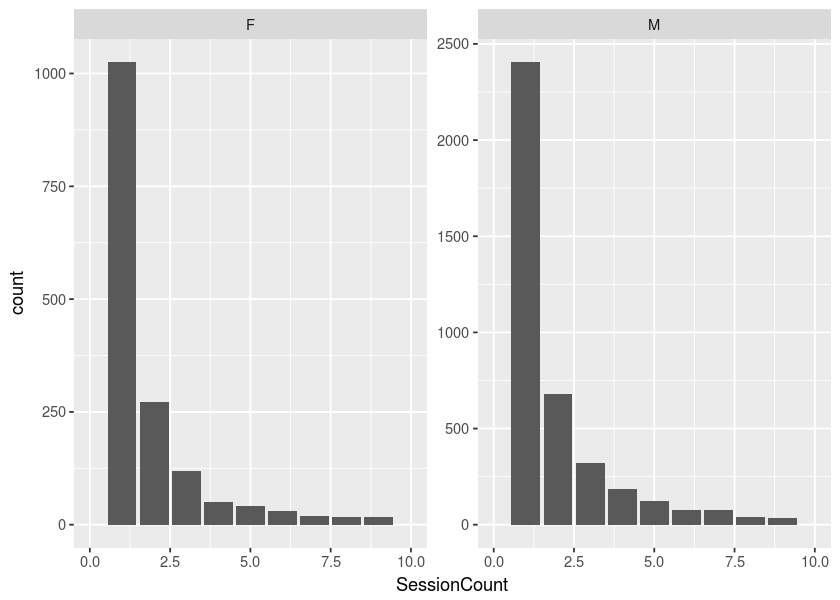

In [13]:
ggplot(all_user_stats) +
    aes(x=SessionCount) +
    geom_bar() +
    facet_wrap(~ gender, scales="free") +
    scale_x_continuous(limits = c(0, 10))

In [15]:
propint = function(successes, count, side="low") {
    prop.test(successes, count)$conf.int[switch(side, low=1, high=2)]
}

In [17]:
retentionSummarizedGender <- all_user_stats %>%
    group_by(gender) %>%
    summarize(nusers=n(),
              freq=mean(Retention),
           #  error=sd(Retention) / sqrt(n()))
              ci.low=propint(sum(Retention),n(), side="low"),
              ci.high=propint(sum(Retention),n(), side="high"))
retentionSummarizedGender


gender,nusers,freq,ci.low,ci.high
F,1709,0.4002341,0.3769650,0.4239562
M,4331,0.4447010,0.4298419,0.4596589


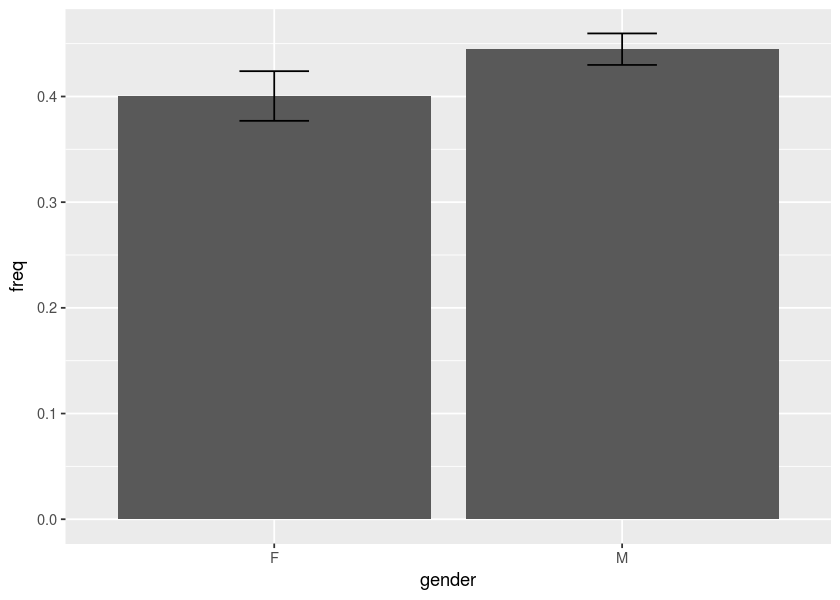

In [18]:
ggplot(retentionSummarizedGender) +
    aes(x=gender, y =freq,ymin=ci.low,ymax=ci.high)  +
    geom_bar(stat="identity") + 
    geom_errorbar(width=0.2)
    #facet_wrap(~ age, scales="free") 
   # scale_x_continuous(limits = c(0, 10))

Proportion test:

In [31]:
with(retentionSummarizedGender, {
    prop.test(nusers * freq, nusers)
})


	2-sample test for equality of proportions with continuity correction

data:  nusers * freq out of nusers
X-squared = 9.6939, df = 1, p-value = 0.001849
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07241769 -0.01651618
sample estimates:
   prop 1    prop 2 
0.4002341 0.4447010 


In [19]:
retentionSummarizedAge <- all_user_stats %>%
    group_by(age) %>%
    summarize(nusers=n(),
              freq=mean(Retention),
              ci.low=propint(sum(Retention),n(), side="low"),
              ci.high=propint(sum(Retention),n(), side="high"))

retentionSummarizedAge

age,nusers,freq,ci.low,ci.high
1-17,222,0.5180180,0.4503192,0.5850831
18-24,1103,0.4605621,0.4308847,0.4905175
25-34,2096,0.4742366,0.4526888,0.4958798
35-44,1193,0.4073764,0.3794221,0.4359341
45-49,550,0.3800000,0.3395153,0.4221865
50-55,496,0.3588710,0.3169164,0.4030463
56+,380,0.3157895,0.2698443,0.3655250


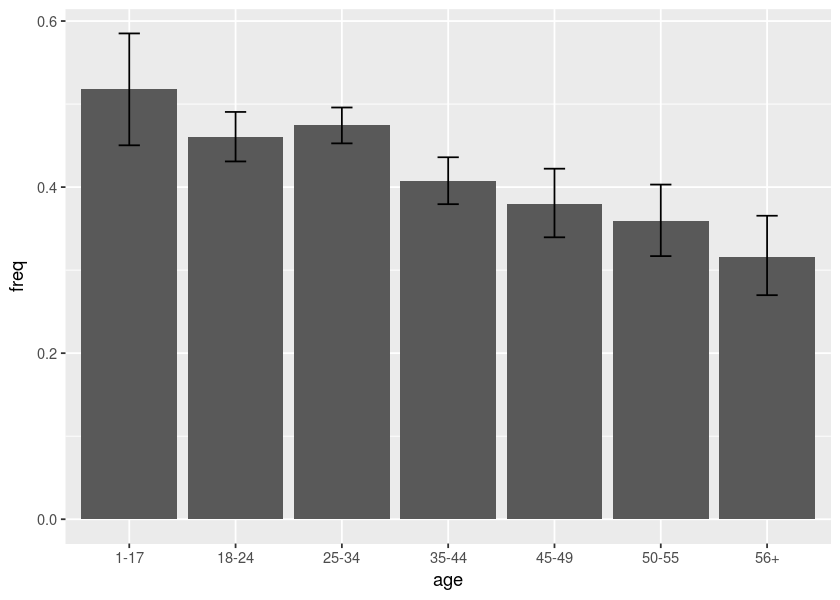

In [20]:
ggplot(retentionSummarizedAge) +
    aes(x=age, y =freq,ymin=ci.low, ymax=ci.high)  +
    geom_bar(stat="identity") + 
    geom_errorbar(width=0.2)

In [21]:
integratedDemo= bind_rows(Gender=retentionSummarizedGender  %>% rename(demoV=gender),
          Age=retentionSummarizedAge %>% rename(demoV=age),
          .id="Demographic")
integratedDemo

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”

Demographic,demoV,nusers,freq,ci.low,ci.high
Gender,F,1709,0.4002341,0.3769650,0.4239562
Gender,M,4331,0.4447010,0.4298419,0.4596589
Age,1-17,222,0.5180180,0.4503192,0.5850831
Age,18-24,1103,0.4605621,0.4308847,0.4905175
Age,25-34,2096,0.4742366,0.4526888,0.4958798
Age,35-44,1193,0.4073764,0.3794221,0.4359341
Age,45-49,550,0.3800000,0.3395153,0.4221865
Age,50-55,496,0.3588710,0.3169164,0.4030463
Age,56+,380,0.3157895,0.2698443,0.3655250


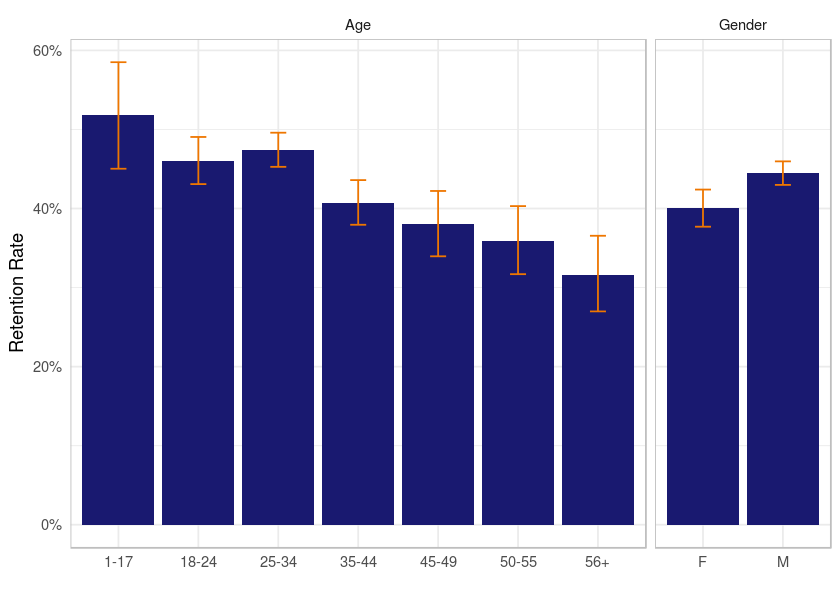

In [30]:
make.plot("ratio-of-retention", width=5, height=2.5, {
ggplot(integratedDemo) +
    aes(x=demoV, y =freq,ymin=ci.low, ymax=ci.high)  +
    geom_bar(stat="identity", fill="midnightblue") + 
    geom_errorbar(width=0.2, color="darkorange2")+
    scale_y_continuous(labels=scales::percent) +
    facet_grid(~ Demographic, scales="free", space="free_x") + xlab("") +ylab("Retention Rate")+
    theme_paper()
    })

Warning message:
“Removed 460 rows containing non-finite values (stat_count).”

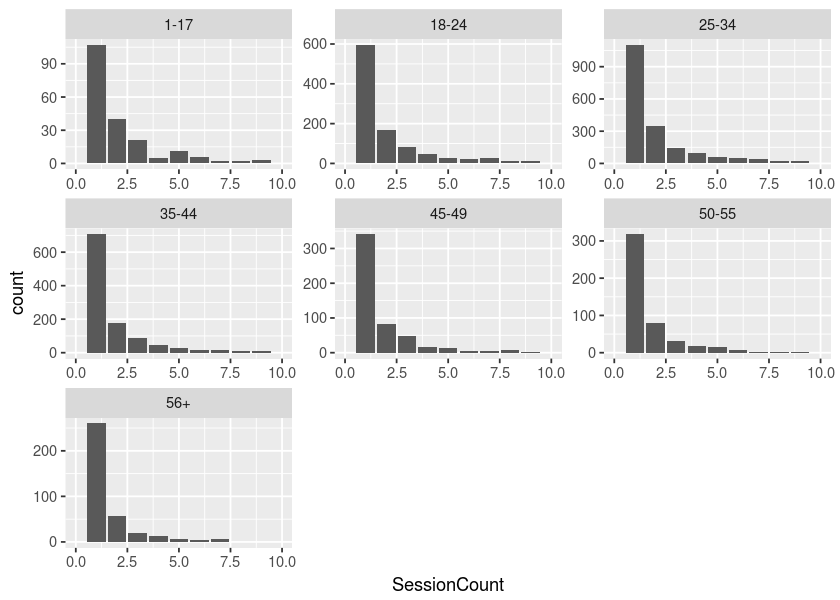

In [50]:
ggplot(all_user_stats) +
    aes(x=SessionCount) +
    geom_bar() +
    facet_wrap(~ age, scales="free") +
    scale_x_continuous(limits = c(0, 10))

Warning message:
“Removed 817 rows containing non-finite values (stat_boxplot).”

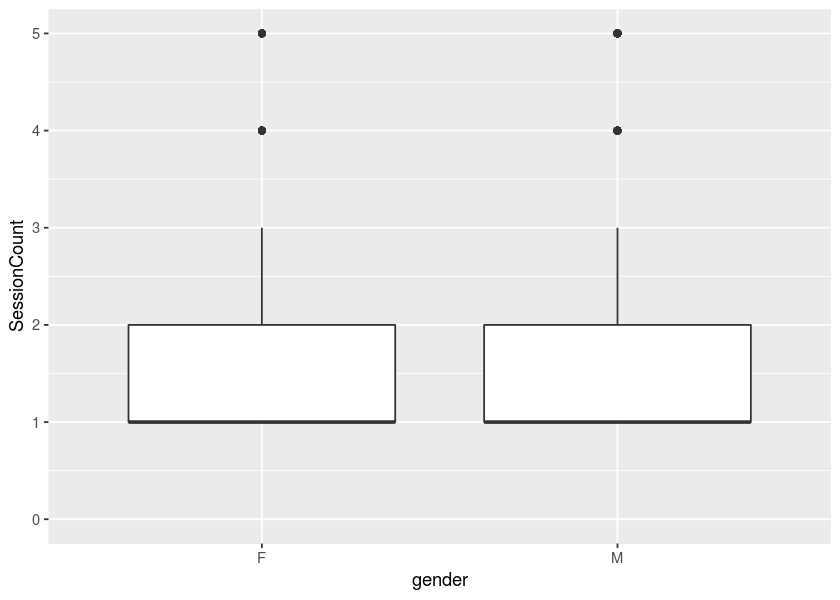

In [51]:
ggplot(all_user_stats, aes(x = gender, y = SessionCount)) +
        geom_boxplot() + scale_y_continuous(limits = c(0, 5))


Warning message:
“Removed 817 rows containing non-finite values (stat_boxplot).”

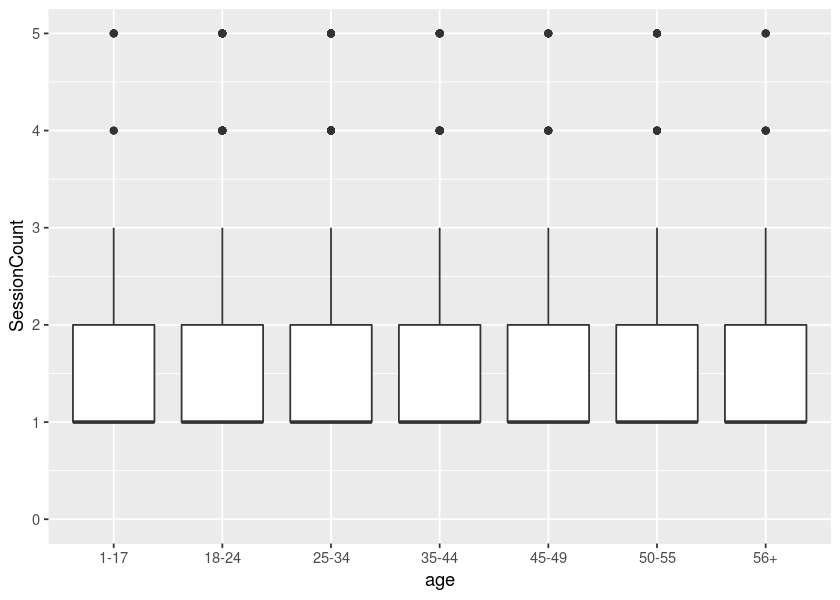

In [52]:
ggplot(all_user_stats, aes(x = age, y = SessionCount)) +
        geom_boxplot() + scale_y_continuous(limits = c(0, 5))

 It doesnt look there is any significant difference.

## Per-Session Count statistics

Do different groups consume different numbers of items, on average?

In [53]:
gender.stats = all_user_stats %>%
    group_by(DataSet, SessionCount) %>%
    summarize(NUsers=n(),
              MeanItemCount=mean(ItemCount),
              ICErr=sd(ItemCount) / sqrt(n()),
              MedItemCount=median(ItemCount))
gender.stats

DataSet,SessionCount,NUsers,MeanItemCount,ICErr,MedItemCount
ML,1,3430,99.8723,1.876451,61
ML,2,952,149.5767,4.718528,103
ML,3,438,215.8950,9.547863,155
ML,4,238,263.9076,16.111747,183
ML,5,165,240.4364,13.722526,204
⋮,⋮,⋮,⋮,⋮,⋮
ML,171,1,839,NA,839
ML,194,1,947,NA,947
ML,227,1,839,NA,839
ML,235,1,1176,NA,1176


Warning message:
“Removed 10 rows containing missing values (position_stack).”Warning message:
“Removed 25 rows containing missing values (geom_errorbar).”

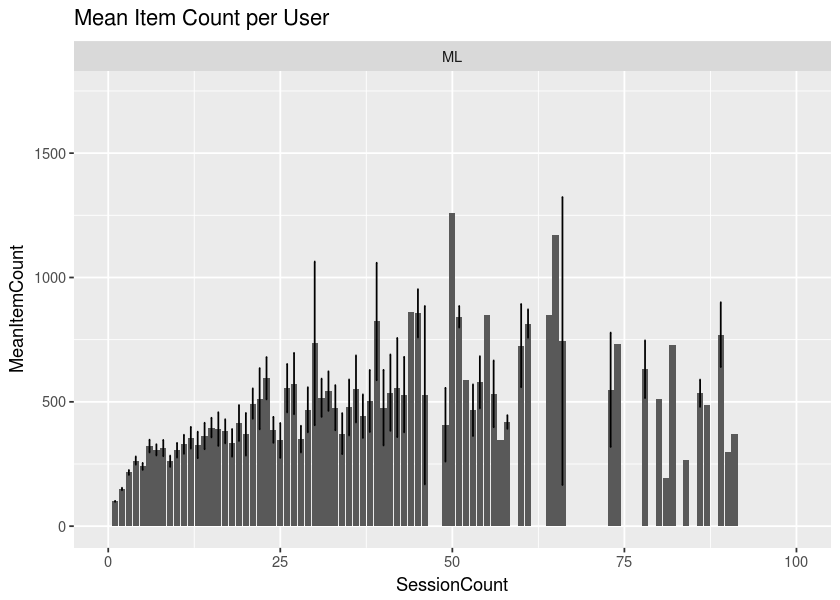

In [54]:
ggplot(gender.stats) +
    aes(x=SessionCount, y=MeanItemCount,
        ymin=MeanItemCount-ICErr,
        ymax=MeanItemCount+ICErr) +
    geom_bar(stat="identity") + geom_errorbar(width=0.2) +
    facet_wrap(~ DataSet) +
    ggtitle("Mean Item Count per User") + scale_x_continuous(limits = c(0, 100))

Warning message:
“Removed 43 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 43 rows containing missing values (position_stack).”Warning message:
“Removed 43 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 43 rows containing missing values (position_stack).”

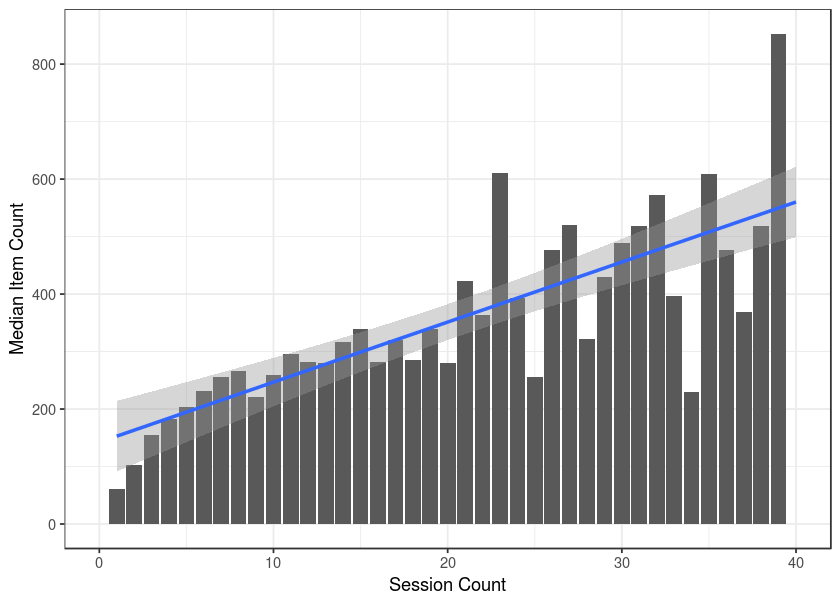

In [55]:
#"lm", "glm", "gam", "loess", "rlm"
make.plot("medianItemCount-by-sessionCount", width=5, height=2.5, {
ggplot(gender.stats) +
    aes(x=SessionCount, y=MedItemCount) +
    geom_bar(stat="identity") +
    #facet_wrap(~ DataSet) +
    ylab("Median Item Count") +
    xlab("Session Count")+
   # ggtitle("Median Item Count per User") +
    scale_x_continuous(limits = c(0, 40)) +
    geom_smooth(method = "lm")+
    theme_bw()
})

The more sessions the more items users rate. Expected.

Do different SessionCounts use higher or lower ratings?

In [ ]:
make.plot("averageRating-by-sessionCount", width=5, height=2.5, {
ggplot(ml_user_stats %>% group_by(SessionCount) %>% summarize(MeanAvgRating=mean(MeanRating))) +
    aes(x=SessionCount, y=MeanAvgRating) +
    geom_bar(stat="identity")+
    scale_x_continuous(limits = c(0,45))+ 
    ylab("Mean Average Rating") +
    xlab("Session Count")+
    coord_cartesian(ylim = c(3, 4)) +
    geom_smooth(method = "lm")+
    theme_bw()
})

Now, let's examine popularity preference.

In [ ]:
make.plot("itemPopularity-by-sessionCount", width=5, height=2.5, {
ggplot(ml_user_stats %>% group_by(SessionCount) %>% summarize(MeanPop=mean(MeanPopRank))) +
    aes(x=SessionCount, y=MeanPop) +
    geom_bar(stat="identity") +
    ylab("Mean Average Popularity") +
    xlab("Session Count")+
#    ggtitle("Popularity Preference by Session Count") + 
    
    scale_x_continuous(limits = c(0, 45))  +
    geom_smooth(method = "lm")+
    theme_bw()
    })

Users with more sessions tend to rate more popular items.